In [1]:
import sys
sys.path.append('..')

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [4]:
diago = torch.arange(20).reshape(2, 10)
diago

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]])

In [5]:
torch.diag_embed(diago)

tensor([[[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  1,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  2,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  3,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  4,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  5,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  6,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  7,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  8,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  9]],

        [[10,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0, 11,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0, 12,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0, 13,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0, 14,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0, 15,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0, 16,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0, 17,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0, 18,  0],
         [ 0,  0,  0,  0,  0,

## Circular CNN 1D

Set easier weights and input vector for easy visualisation

In [55]:
n_in = 10
kernel_size = 5
dilation = 2
padding_mode = "circular"
conv_layer_simple = torch.nn.Conv1d(
    1,
    1,
    kernel_size,
    padding=(kernel_size // 2) * dilation,
    dilation=dilation,
    padding_mode=padding_mode,
    bias=False,
)
# in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None
conv_layer_simple.weight = torch.nn.Parameter(torch.ones_like(conv_layer_simple.weight))
x = torch.rand(size=(1, 1, 10))
for i in range(n_in):
    x[:, :, i] = 1.0 * i + 1
print(x, x.shape)
print(conv_layer_simple(x), conv_layer_simple(x).shape)


# conv_layer_simple = torch.nn.Conv1d(1, 1, kernel_size, padding=kernel_size//2, dilation=3, padding_mode=padding_mode, bias=False)
# # in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None
# # conv_layer_simple.weight = torch.nn.Parameter(torch.ones_like(conv_layer_simple.weight))
# print(x)
# print(conv_layer_simple(x))
conv_layers_dilations = []
for dilation in [1, 2, 4]:
    conv_layers_dilations.append(
        torch.nn.Conv1d(
            1,
            1,
            kernel_size,
            padding=(kernel_size // 2) * dilation,
            dilation=dilation,
            padding_mode=padding_mode,
            bias=False,
        )
    )


class ParallelConv1DDilations(torch.nn.Module):
    def __init__(self, n_in, dilation_list, kernel_size):
        self.n_in = n_in
        self.dilation_list = dilation_list
        self.kernel_size = kernel_size
        self.conv_layers_dilations = []
        for dilation in self.dilation_list:
            self.conv_layers_dilations.append(
                torch.nn.Conv1d(
                    1,
                    1,
                    self.kernel_size,
                    padding=(self.kernel_size // 2) * dilation,
                    dilation=dilation,
                    padding_mode=padding_mode,
                    bias=False,
                )
            )

    def forward(self, x):
        return torch.concatenate(
            [conv_layer.forward(x) for conv_layer in self.conv_layers_dilations], dim=1
        )
        

tensor([[[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]]]) torch.Size([1, 1, 10])
tensor([[[25., 30., 25., 30., 25., 30., 25., 30., 25., 30.]]],
       grad_fn=<ConvolutionBackward0>) torch.Size([1, 1, 10])


In [58]:
parconv = ParallelConv1DDilations(10, [1, 2, 4], kernel_size=3)
x = torch.rand((2, 1, 10))
parconv.forward(x)
# parconv.conv_layers_dilations[0](x)

tensor([[[ 0.1120, -0.2639,  0.0031, -0.1549, -0.2375,  0.0671, -0.1858,
           0.0051, -0.1655, -0.0495],
         [ 0.0411,  0.1064, -0.0354,  0.3129,  0.0115,  0.0154,  0.0843,
           0.0265,  0.1328, -0.2361],
         [ 0.2629,  0.4463,  0.3205,  0.4201,  0.4206, -0.0125,  0.3739,
           0.3169,  0.2941,  0.4365]],

        [[ 0.1675, -0.2076, -0.0058, -0.1177, -0.0787, -0.0818, -0.0606,
           0.1404, -0.2460, -0.0282],
         [-0.0048,  0.1183, -0.0030,  0.1453,  0.0798,  0.1004, -0.1710,
           0.0563,  0.2317, -0.2793],
         [ 0.1675,  0.4078,  0.0153,  0.2796,  0.3675, -0.0599,  0.0906,
           0.2171,  0.3069,  0.1626]]], grad_fn=<CatBackward0>)

In [ ]:
conv_layer_vec = torch.nn.Conv1d(1, 5, kernel_size, padding=kernel_size//2, padding_mode=padding_mode, bias=True)
layers_vec = torch.nn.Sequential(conv_layer_vec, torch.nn.Conv1d(5, 5, kernel_size, padding=kernel_size//2, padding_mode=padding_mode, bias=True))

In [ ]:
conv_layer_val = torch.nn.Conv1d(1, 1, kernel_size, padding=kernel_size//2, padding_mode=padding_mode, bias=True)
layers_val = torch.nn.Sequential(conv_layer_val, torch.nn.Flatten(), torch.nn.Linear(n_in, 5))

In [ ]:
def construct_conv1D(n_in, n_c, kernel_size):
    padding_mode = 'circular'

    layers_vec = torch.nn.Sequential(
        torch.nn.Conv1d(
            1, n_c, kernel_size, padding=kernel_size // 2, padding_mode=padding_mode
        ),
        torch.nn.LeakyReLU(),
        torch.nn.Conv1d(
            n_c, n_c, kernel_size, padding=kernel_size // 2, padding_mode=padding_mode
        ),        
        torch.nn.LeakyReLU(),
        torch.nn.Conv1d(
            n_c, n_c, kernel_size, padding=kernel_size // 2, padding_mode=padding_mode
        )
    )
    return layers_vec

def construct_conv1D_singularvalue(n_in, n_c, kernel_size):
    padding_mode = 'circular'
    layers_vec = torch.nn.Sequential(
        torch.nn.Conv1d(
            1, n_c, kernel_size, padding=kernel_size // 2, padding_mode=padding_mode
        ),
        torch.nn.LeakyReLU(),
        torch.nn.Conv1d(
            n_c, n_c, kernel_size, padding=kernel_size // 2, padding_mode=padding_mode
        ),
        torch.nn.AdaptiveAvgPool1d(1)
)
    return layers_vec

class ConvLayersSVD(torch.nn.Module):
    def __init__(self, state_dimension, n_latent, kernel_size) -> None:
        super().__init__()
        self.state_dimension = state_dimension
        self.n_latent = n_latent
        self.kernel_size = kernel_size
        self.layers_vec = construct_conv1D(self.state_dimension, self.n_latent, kernel_size=self.kernel_size)
        self.layers_sing = construct_conv1D_singularvalue(self.state_dimension, self.n_latent, kernel_size=self.kernel_size)
    
    def forward(self, x):
        x = torch.atleast_2d(x)
        x = x.view(len(x), 1, -1)
        n_batch = len(x)
        vectors = torch.nn.functional.normalize(self.layers_vec(x), dim=-1)
        # print(vectors.shape)
        singvals = self.layers_sing(x)
        # print(singvals.shape)
        return torch.concat((vectors, singvals.view(n_batch, self.n_latent, 1)), -1).transpose(1, 2)

In [ ]:
n_batch = 3

In [ ]:
cvlay = ConvLayersSVD(n_in, 5, 3)


In [ ]:
cvlay(x)

tensor([[[ 0.2980,  0.4329, -0.3129,  0.1985, -0.1530],
         [ 0.2880,  0.0788, -0.2610,  0.3299, -0.3597],
         [ 0.2960,  0.2517, -0.3093,  0.3250, -0.2888],
         [ 0.3027,  0.2783, -0.2933,  0.2723, -0.2972],
         [ 0.3030,  0.2961, -0.3143,  0.4179, -0.2969],
         [ 0.3159,  0.3660, -0.2843,  0.1142, -0.2591],
         [ 0.3317,  0.0852, -0.2947,  0.4397, -0.5066],
         [ 0.3581,  0.4299, -0.3672,  0.1789, -0.2540],
         [ 0.3374,  0.2407, -0.3371,  0.3176, -0.3805],
         [ 0.3244,  0.4403, -0.3706,  0.3976, -0.2328],
         [ 0.0846,  0.1798,  0.2533,  0.0216, -0.2732]],

        [[ 0.3217,  0.3604, -0.3406,  0.1952, -0.2250],
         [ 0.2971,  0.2094, -0.3225,  0.4123, -0.3136],
         [ 0.2790,  0.3533, -0.3344,  0.2996, -0.1504],
         [ 0.2641,  0.1481, -0.2412,  0.2960, -0.2601],
         [ 0.2893,  0.1477, -0.2717,  0.3430, -0.3383],
         [ 0.3152,  0.2503, -0.2926,  0.2367, -0.3360],
         [ 0.3523,  0.2426, -0.3082,  0.3103, 

In [ ]:
x = torch.linspace(0, n_in - 1, n_in * nbatch).reshape(nbatch, 1, n_in)
lays = construct_conv1D(n_in, 5, 3)
lays(x).transpose(1, 2).shape
print(y := torch.nn.functional.normalize(lays(x).transpose(1, 2)))
y.norm(dim=1), print(y.shape)
cc=  construct_conv1D_singularvalue(n_in, 5, 3)

tensor([[[-0.1358,  0.0990, -0.3278, -0.2547,  0.2109],
         [-0.0716,  0.0615, -0.3629, -0.1930,  0.3808],
         [-0.0047,  0.3467, -0.3492,  0.1315,  0.3603],
         [ 0.3694,  0.3933, -0.2941,  0.3996,  0.3424],
         [ 0.3567,  0.3802, -0.2952,  0.3840,  0.3458],
         [ 0.3439,  0.3672, -0.2964,  0.3683,  0.3493],
         [ 0.3312,  0.3541, -0.2975,  0.3527,  0.3527],
         [ 0.2965,  0.3460, -0.3230,  0.3306,  0.3227],
         [ 0.5737,  0.4267, -0.2949,  0.2376,  0.2588],
         [ 0.2601, -0.0710, -0.3123, -0.3843,  0.1624]],

        [[-0.1985, -0.1614, -0.3306, -0.5375,  0.1905],
         [-0.3148, -0.3894, -0.3626, -0.4574,  0.4222],
         [-0.1900,  0.2896, -0.3514, -0.2018,  0.3650],
         [ 0.3226,  0.3429, -0.2973,  0.0481,  0.3927],
         [ 0.3133,  0.3081, -0.2987,  0.0047,  0.3705],
         [ 0.3039,  0.2733, -0.3001, -0.0386,  0.3483],
         [ 0.2946,  0.2384, -0.3015, -0.0820,  0.3262],
         [ 0.2616,  0.2316, -0.3149, -0.0938, 

In [ ]:
cc(x).shape

torch.Size([3, 5, 1])

In [ ]:
print(f"{x.shape=}, {y.shape=}")
print(f"{x.shape=}, {layers_vec(x).shape=}")
print(f"{x.shape=}, {layers_val(x).shape=}")
y, z = layers_vec(x), layers_val(x)
y.shape, z.shape


x.shape=torch.Size([3, 1, 10]), y.shape=torch.Size([3, 10, 5])
x.shape=torch.Size([3, 1, 10]), layers_vec(x).shape=torch.Size([3, 5, 10])
x.shape=torch.Size([3, 1, 10]), layers_val(x).shape=torch.Size([3, 5])


(torch.Size([3, 5, 10]), torch.Size([3, 5]))

torch.Size([3, 11, 5])

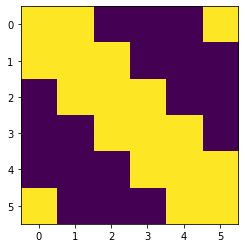

In [ ]:
conv_matrix = torch.zeros((n_in, n_in))
for i in range(n_in):
    conv_matrix[i, i % n_in] = 1.0
    for j in range(kernel_size):
        conv_matrix[i, (i+j - kernel_size//2) % n_in] = 1.0
plt.imshow(conv_matrix)

In [ ]:
(conv_matrix @ x.squeeze() == y).all()

tensor(True)

In [ ]:
print(x)
print(y)

tensor([[[0., 1., 2., 3., 4., 5.]]])
tensor([[[ 6.,  3.,  6.,  9., 12.,  9.]]], grad_fn=<SqueezeBackward1>)


## Self Attention Layer

In [ ]:
embed_dim = 1

In [ ]:
attention_layer = torch.nn.MultiheadAttention(embed_dim=embed_dim, num_heads=1)